In [ ]:
!pip install pybloom-live cuckoopy matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.9/332.9 kB 7.1 MB/s eta 0:00:00
  Created wheel for pybloom-live: filename=pybloom_live-4.0.0-py3-none-any.whl size=9229 sha256=45b39143621450cc3869212acf4d1bec8017ab47e2a24da822c0434f15771a78
  Stored in directory: /root/.cache/pip/wheels/1d/5e/b8/19c04c108b0acd2ca53b85fcc09eeed323ecdfea0e36bd134e
Successfully built pybloom-live


In [ ]:
%%writefile dataset.py
"""
dataset.py

Utilities for generating and loading datasets of unique usernames.
This version generates fixed-length 6-character usernames.
"""
import os
import gzip
import random
import string
from typing import List

# --- THIS IS THE ONLY FUNCTION THAT HAS CHANGED ---
def generate_username(rand: random.Random) -> str:
    """
    Generates a random 6-character alphanumeric username.
    The character set includes a-z, A-Z, and 0-9.
    """
    # Define the pool of characters to choose from
    chars = string.ascii_letters + string.digits
    # Return a random string of length 6
    return ''.join(rand.choices(chars, k=6))
# --------------------------------------------------

def generate_dataset_file(path: str, n: int, seed: int = 42) -> None:
    """
    Generate n unique usernames and write them to a specified path.
    The file is gzipped if the path ends with .gz.
    """
    print(f"Generating dataset with {n} items at {path}...")
    rand = random.Random(seed)
    seen = set()

    dirname = os.path.dirname(path)
    if dirname:
        os.makedirs(dirname, exist_ok=True)

    opener = gzip.open if path.endswith('.gz') else open
    with opener(path, 'wt', encoding='utf-8') as f:
        # This loop ensures uniqueness. If a duplicate is generated,
        # it's simply skipped and another is created.
        while len(seen) < n:
            u = generate_username(rand)
            if u not in seen:
                seen.add(u)
                f.write(u + '\n')
    print("Dataset generation complete.")

def load_dataset(path: str) -> List[str]:
    """
    Loads a dataset of usernames from a file.
    """
    print(f"Loading dataset from {path}...")
    opener = gzip.open if path.endswith('.gz') else open
    data = []
    with opener(path, 'rt', encoding='utf-8', errors='ignore') as f:
        for line in f:
            s = line.strip()
            if s:
                data.append(s)
    print(f"Loaded {len(data)} items.")
    return data

Writing dataset.py


In [ ]:
%%writefile checkers.py
"""
checkers.py

Contains the abstract base class Checker and its concrete implementations.
"""
import bisect
from abc import ABC, abstractmethod
from typing import Iterable, List

from pybloom_live import BloomFilter
from cuckoopy import CuckooFilter

class Checker(ABC):
    @abstractmethod
    def build(self, items: Iterable[str]) -> None:
        raise NotImplementedError

    @abstractmethod
    def contains(self, item: str) -> bool:
        raise NotImplementedError

class ListChecker(Checker):
    def __init__(self):
        self._data: List[str] = []
    def build(self, items: Iterable[str]) -> None:
        self._data = list(items)
    def contains(self, item: str) -> bool:
        return item in self._data

class SortedListChecker(Checker):
    def __init__(self):
        self._data: List[str] = []
    def build(self, items: Iterable[str]) -> None:
        self._data = sorted(list(items))
    def contains(self, item: str) -> bool:
        i = bisect.bisect_left(self._data, item)
        return i != len(self._data) and self._data[i] == item

class HashChecker(Checker):
    def __init__(self):
        self._data = set()
    def build(self, items: Iterable[str]) -> None:
        self._data = set(items)
    def contains(self, item: str) -> bool:
        return item in self._data

class PyBloomChecker(Checker):
    def __init__(self, capacity: int, error_rate: float = 0.001):
        self.capacity = capacity
        self.error_rate = error_rate
        self._filter: BloomFilter = None
    def build(self, items: Iterable[str]) -> None:
        self._filter = BloomFilter(capacity=self.capacity, error_rate=self.error_rate)
        for item in items:
            self._filter.add(item)
    def contains(self, item: str) -> bool:
        return item in self._filter

class CuckoopyChecker(Checker):
    def __init__(self, capacity: int, bucket_size: int = 4, fingerprint_size: int = 2):
        self.capacity = capacity
        self.bucket_size = bucket_size
        self.fingerprint_size = fingerprint_size
        self._filter: CuckooFilter = None
    def build(self, items: Iterable[str]) -> None:
        self._filter = CuckooFilter(
            capacity=self.capacity, bucket_size=self.bucket_size, fingerprint_size=self.fingerprint_size
        )
        for item in items:
            self._filter.insert(item)
    def contains(self, item: str) -> bool:
        return self._filter.contains(item)

Writing checkers.py


In [ ]:
%%writefile main.py
"""
main.py - Main script to run the login checker experiments.
"""
import argparse
import csv
import os
import random
import string
import time
import tracemalloc
from typing import List, Tuple, Dict, Any

import matplotlib
matplotlib.use('Agg') # Use a non-interactive backend for saving plots
import matplotlib.pyplot as plt

from dataset import generate_dataset_file, load_dataset
from checkers import (
    Checker, ListChecker, SortedListChecker, HashChecker,
    PyBloomChecker, CuckoopyChecker
)

def generate_queries(
    dataset: List[str], q: int, hit_ratio: float = 0.5, seed: int = 123
) -> List[str]:
    rand = random.Random(seed)
    n = len(dataset)
    dataset_set = set(dataset)
    num_hits = int(q * hit_ratio)
    num_misses = q - num_hits
    hits = rand.sample(dataset, min(num_hits, n))
    misses = []
    while len(misses) < num_misses:
        s = 'zz_miss_' + ''.join(rand.choices(string.ascii_lowercase + string.digits, k=12))
        if s not in dataset_set:
            misses.append(s)
    queries = hits + misses
    random.shuffle(queries)
    return queries

def time_build_and_queries(checker: Checker, dataset: List[str], queries: List[str]) -> Tuple[float, float, int]:
    tracemalloc.start()
    t0 = time.perf_counter()
    checker.build(dataset)
    t1 = time.perf_counter()
    t2 = time.perf_counter()
    for q in queries:
        checker.contains(q)
    t3 = time.perf_counter()
    _, peak_mem_bytes = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return (t1 - t0), (t3 - t2), peak_mem_bytes

def run_experiments(
    dataset_paths: List[Tuple[int, str]], outdir: str, queries_per_run: int
) -> None:
    os.makedirs(outdir, exist_ok=True)
    results_csv = os.path.join(outdir, 'results.csv')
    fieldnames = ['n', 'method', 'build_time_s', 'total_lookup_time_s', 'avg_lookup_time_s', 'peak_mem_bytes']
    with open(results_csv, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for n, path in dataset_paths:
            print(f"\n{'='*15} Running experiments for n={n} {'='*15}")
            dataset = load_dataset(path)
            queries = generate_queries(dataset, q=queries_per_run)
            methods = {
                "list": ListChecker(),
                "sorted": SortedListChecker(),
                "hash": HashChecker(),
                "bloom": PyBloomChecker(capacity=n),
                "cuckoo": CuckoopyChecker(capacity=n)
            }
            for name, checker in methods.items():
                # if name == 'list' and n > 200_000:
                #     print(f"Skipping '{name}' for n={n} (too slow).")
                #     continue
                print(f"-> Benchmarking '{name}'...")
                build_t, lookup_t, peak_mem = time_build_and_queries(checker, dataset, queries)
                print(f"   Build Time: {build_t:.4f}s | Total Lookup Time: {lookup_t:.4f}s | Peak Memory: {peak_mem / 1024**2:.2f} MiB")
                writer.writerow({
                    'n': n, 'method': name, 'build_time_s': build_t, 'total_lookup_time_s': lookup_t,
                    'avg_lookup_time_s': lookup_t / len(queries), 'peak_mem_bytes': peak_mem,
                })
    print(f"\nAll experiments complete. Results written to {results_csv}")
    plot_results(results_csv, outdir)

def plot_results(csv_path: str, outdir: str) -> None:
    data: Dict[str, List[Dict[str, Any]]] = {}
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            method = row['method']
            if method not in data: data[method] = []
            data[method].append(row)
    plots_to_generate = {
        "avg_lookup_time_s": "Average Lookup Time (s, log scale)",
        "build_time_s": "Build Time (s, log scale)",
        "peak_mem_bytes": "Peak Memory Usage (MiB, log scale)"
    }
    for key, ylabel in plots_to_generate.items():
        plt.figure(figsize=(10, 7))
        for method, rows in data.items():
            xs = [int(r['n']) for r in rows]
            ys = [int(r['peak_mem_bytes']) / 1024**2 for r in rows] if key == 'peak_mem_bytes' else [float(r[key]) for r in rows]
            plt.plot(xs, ys, marker='o', linestyle='-', label=method)
        plt.xscale('log'); plt.yscale('log'); plt.xlabel('Number of Items (n, log scale)'); plt.ylabel(ylabel)
        plt.title(f'{key.replace("_", " ").title()} vs. Number of Items'); plt.legend(); plt.grid(True, which="both", ls="--")
        output_path = os.path.join(outdir, f'{key}_vs_n.png')
        plt.savefig(output_path); plt.close()
        print(f"Saved plot: {output_path}")

def main():
    parser = argparse.ArgumentParser(description="Run Login Checker experiments.")
    parser.add_argument('--outdir', type=str, default='results', help='Directory to store datasets and results.')
    parser.add_argument('--ns', nargs='+', type=int, default=[10000, 100000, 500000], help='List of n values (dataset sizes).')
    parser.add_argument('--queries', type=int, default=10000, help='Number of queries to run per experiment.')
    parser.add_argument('--generate', action='store_true', help='Flag to generate new datasets.')
    parser.add_argument('--run', action='store_true', help='Flag to run the benchmark experiments.')
    args = parser.parse_args()
    dataset_paths = []
    for n in sorted(args.ns):
        fname = f"usernames_n{n}.txt.gz"
        path = os.path.join(args.outdir, 'datasets', fname)
        dataset_paths.append((n, path))
    if args.generate:
        for n, path in dataset_paths:
            if os.path.exists(path):
                print(f"Dataset {path} already exists, skipping generation.")
            else:
                generate_dataset_file(path, n)
    if args.run:
        run_experiments(dataset_paths, args.outdir, args.queries)

if __name__ == '__main__':
    main()

Writing main.py


In [ ]:
# Run the full experiment: generate datasets and run benchmarks
# Using n values from 10k up to 1 million
!python main.py --ns 100000 1000000 10000000 --generate --run

Generating dataset with 100000 items at results/datasets/usernames_n100000.txt.gz...
Dataset generation complete.
Generating dataset with 1000000 items at results/datasets/usernames_n1000000.txt.gz...
Dataset generation complete.
Generating dataset with 10000000 items at results/datasets/usernames_n10000000.txt.gz...
Dataset generation complete.

=============== Running experiments for n=100000 ===============
Loading dataset from results/datasets/usernames_n100000.txt.gz...
Loaded 100000 items.
-> Benchmarking 'list'...
   Build Time: 0.0006s | Total Lookup Time: 11.5536s | Peak Memory: 0.76 MiB
-> Benchmarking 'sorted'...
   Build Time: 0.0443s | Total Lookup Time: 0.0219s | Peak Memory: 1.91 MiB
-> Benchmarking 'hash'...
   Build Time: 0.0060s | Total Lookup Time: 0.0018s | Peak Memory: 6.00 MiB
-> Benchmarking 'bloom'...
   Build Time: 6.0514s | Total Lookup Time: 0.4352s | Peak Memory: 0.17 MiB
-> Benchmarking 'cuckoo'...
   Build Time: 4.4547s | Total Lookup Time: 1.0515s | Peak 

Displaying results/avg_lookup_time_s_vs_n.png


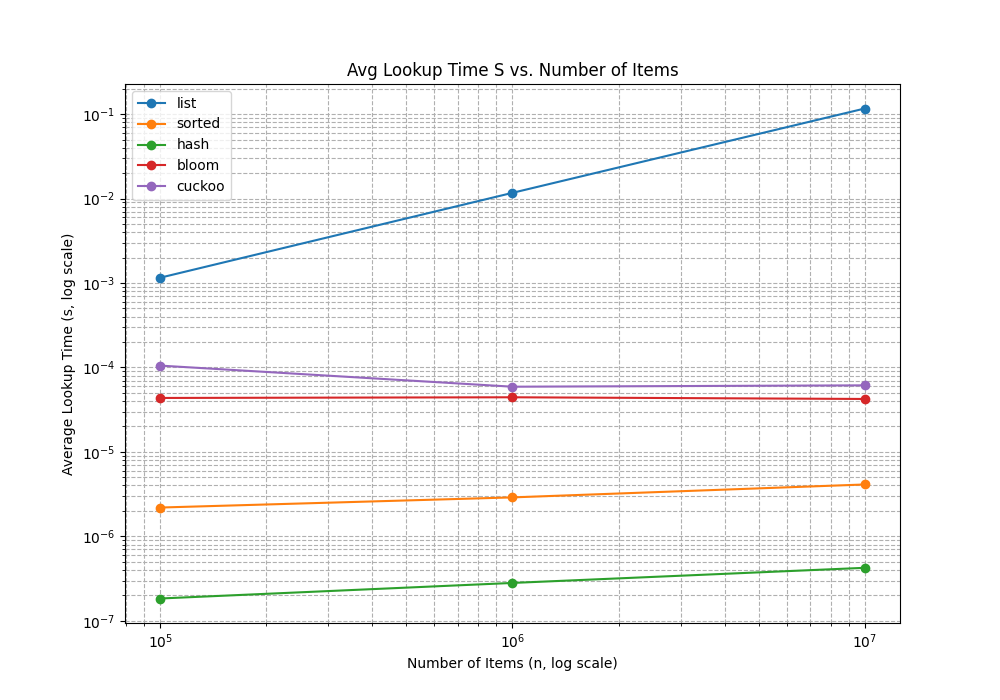

------------------------------
Displaying results/build_time_s_vs_n.png


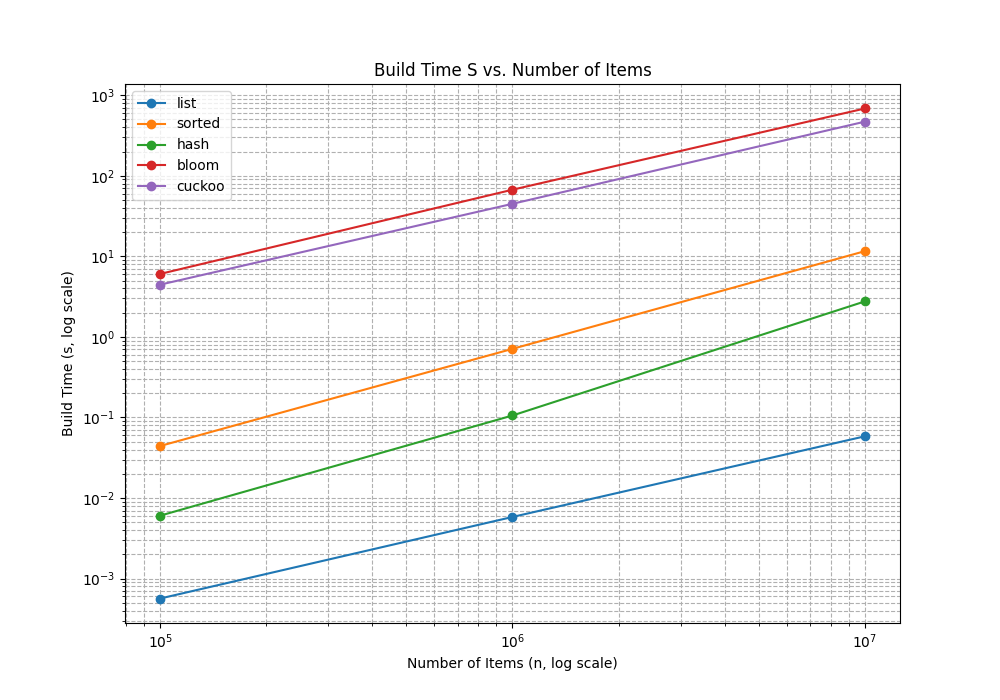

------------------------------
Displaying results/peak_mem_bytes_vs_n.png


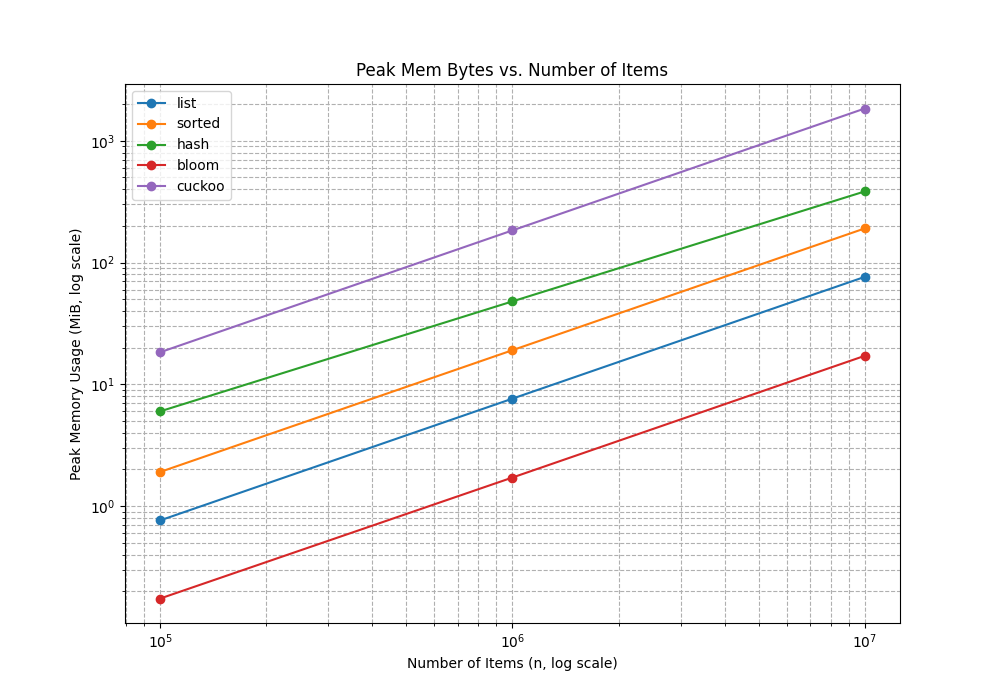

------------------------------


In [ ]:
from IPython.display import Image, display

# List of generated plot files
plot_files = [
    'results/avg_lookup_time_s_vs_n.png',
    'results/build_time_s_vs_n.png',
    'results/peak_mem_bytes_vs_n.png'
]

for file_path in plot_files:
    print(f"Displaying {file_path}")
    display(Image(filename=file_path))
    print("-" * 30)

In [ ]:
%%writefile test_checkers.py
"""
test_checkers.py

Unit tests for all Checker implementations to ensure correctness.
NOTE: This file is independent of dataset.py and does not need to be
changed, as it uses its own simple, hardcoded data for testing.
"""
import unittest
from checkers import (
    ListChecker, SortedListChecker, HashChecker,
    PyBloomChecker, CuckoopyChecker
)

class TestCheckers(unittest.TestCase):

    def setUp(self):
        """Set up a common dataset and initialize all checkers."""
        self.items = ["apple", "banana", "cherry", "date"]
        self.checkers = {
            "list": ListChecker(),
            "sorted": SortedListChecker(),
            "hash": HashChecker(),
            "bloom": PyBloomChecker(capacity=len(self.items), error_rate=0.01),
            "cuckoo": CuckoopyChecker(capacity=len(self.items))
        }
        for checker in self.checkers.values():
            checker.build(self.items)

    def test_contains_existing_items(self):
        """Test that all checkers correctly find items that exist."""
        for name, checker in self.checkers.items():
            with self.subTest(checker=name):
                self.assertTrue(checker.contains("apple"))
                self.assertTrue(checker.contains("cherry"))

    def test_does_not_contain_non_existing_items(self):
        """
        Test that checkers do not find items that don't exist.
        """
        non_existing_items = ["grape", "orange", "mango"]
        for name, checker in self.checkers.items():
            with self.subTest(checker=name):
                for item in non_existing_items:
                    # Exact data structures must return False
                    if name in ["list", "sorted", "hash"]:
                        self.assertFalse(checker.contains(item))
                    # For probabilistic filters, we just run it to ensure no errors.
                    else:
                        checker.contains(item) # No assertion

    def test_empty_build(self):
        """Test that building with an empty list works correctly."""
        for name, checker in self.checkers.items():
            with self.subTest(checker=name):
                checker.build([])
                self.assertFalse(checker.contains("apple"))

# To run the tests from a notebook cell, you can use this:
if __name__ == '__main__':
    # The 'argv' and 'exit' parameters help it run smoothly inside a notebook
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

Writing test_checkers.py


In [ ]:
!python test_checkers.py

...
----------------------------------------------------------------------
Ran 3 tests in 0.001s

OK
